# Very naive deep learning on the vector of surrounding bases

---

### Data

Naive feature vectors. The original sequence of validation/test and train data does not overlap! ( but train data points can overlap with train data points, and test-validation can overlap with test-validation data ) This overlapping does not lead to unintentional label leakage!



### Notes


---

Instruct theano to use gpu

In [2]:
import os
os.environ['THEANO_FLAGS']='device=gpu'

import sys
sys.path.append('../my_modules')
from loading_utils import read_my_data

import subprocess
import time

import numpy as np
import pandas as pd

import os,subprocess
workdir='/mnt/Data1/ribli/methylation_code/modelling'
subprocess.call(['mkdir',workdir])
os.chdir(workdir)

### Load data

In [3]:
train_id,train_x,train_y = read_my_data(
    fname='../prepare_data/diffmet_train_feat_vect.csv')
test_id,test_x,test_y = read_my_data(
    fname='../prepare_data/diffmet_test_feat_vect.csv')

Loading data... 
Loading data... 


### One-hot encode them into 2d image

In [4]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.concatenate([train_x.flatten(),test_x.flatten()]))

one_hot_train_x=lb.transform(train_x.flatten()).reshape((-1,1,1000,4))
one_hot_test_x=lb.transform(test_x.flatten()).reshape((-1,1,1000,4))

### Build convnet

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D,MaxPooling2D

input_dim=one_hot_train_x.shape[2]
activation='relu'
loss='binary_crossentropy'
optimizer='adadelta'
init='uniform'
pool_size=(991,1)
window_size=10

model = Sequential()

#Convolution layer
model.add(Convolution2D(40,window_size,4, border_mode='valid',input_shape=(1,input_dim,4)))
model.add(Activation(activation))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dropout(0.2))

#final layer
model.add(Dense(1, activation='sigmoid'))


#compile model
model.compile(loss=loss,optimizer=optimizer,class_mode='binary')

Using Theano backend.
Using gpu device 0: GeForce GTX 670 (CNMeM is disabled, CuDNN not available)
/mnt/Data1/ribli/tools/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


### Train and test model

In [6]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
def fit_keras_model(model,train_x,train_y,test_x,test_y,validation_split=0.05):
    start=time.time()
    
    #callbacks
    best_model=ModelCheckpoint('best_model',save_best_only=True,verbose=1)
    early_stop=EarlyStopping(patience=7,verbose=1)
    
    #train it
    callb_hist=model.fit(train_x,train_y,nb_epoch = 100,
                         show_accuracy=True,verbose=1,
                        validation_split=validation_split,
                        callbacks=[best_model,early_stop])
    #predict
    model.load_weights('best_model')
    train_pred=model.predict_classes(train_x).ravel()
    test_pred=model.predict_classes(test_x).ravel()
    
    train_pred_pr=model.predict(train_x).ravel()
    test_pred_pr=model.predict(test_x).ravel()

    #check errors
    print 'train accuracy:',list((train_pred==train_y)).count(True)/float(len(train_y))
    print 'test accuracy:',list((test_pred==test_y)).count(True)/float(len(test_y))

    print 'It took:',time.time()-start    
    return train_pred,test_pred,train_pred_pr,test_pred_pr

In [7]:
train_pred,test_pred,train_pred_pr,test_pred_pr=fit_keras_model(
    model,one_hot_train_x,train_y,one_hot_test_x,test_y,validation_split=0.2)

print '\nprediction balance:'
print np.mean(train_pred)
print np.mean(test_pred)

Train on 5155 samples, validate on 1289 samples
Epoch 1/100
5155/5155 [==============================] - 2s - loss: 0.9354 - acc: 0.5094 - val_loss: 0.6879 - val_acc: 0.5500
Epoch 00000: val_loss improved from inf to 0.68786, saving model to best_model
Epoch 2/100
5155/5155 [==============================] - 2s - loss: 0.7540 - acc: 0.5049 - val_loss: 0.6837 - val_acc: 0.5586
Epoch 00001: val_loss improved from 0.68786 to 0.68366, saving model to best_model
Epoch 3/100
5155/5155 [==============================] - 2s - loss: 0.7346 - acc: 0.5160 - val_loss: 0.6976 - val_acc: 0.4950
Epoch 00002: val_loss did not improve
Epoch 4/100
5155/5155 [==============================] - 2s - loss: 0.7173 - acc: 0.5143 - val_loss: 0.7000 - val_acc: 0.4934
Epoch 00003: val_loss did not improve
Epoch 5/100
5155/5155 [==============================] - 2s - loss: 0.7043 - acc: 0.5364 - val_loss: 0.6772 - val_acc: 0.5764
Epoch 00004: val_loss improved from 0.68366 to 0.67720, saving model to best_model
E

### roc and auc

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline

from sklearn import metrics
def plot_roc(y,probs):
    fpr, tpr, thresholds = metrics.roc_curve(y,probs)
    auc=metrics.roc_auc_score(y,probs)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr,tpr,lw=2)
    plt.plot([0,1],[0,1],lw=2)
    plt.xlim(-0.01,1.01)
    plt.ylim(-0.01,1.01)
    plt.xlabel('FP rate')
    plt.ylabel('TP rate')
    print 'auc:',auc

auc: 0.720730769231


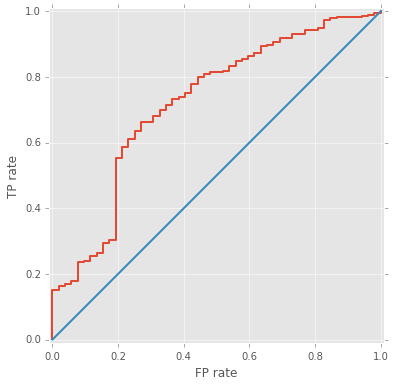

In [11]:
plot_roc(test_y,test_pred_pr)

### Kernels

In [13]:
conv1=model.layers[0]
weigths,bias=conv1.get_weights()

dense1=model.layers[5]
weigths2,bias2=dense1.get_weights()

/mnt/Data1/ribli/tools/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


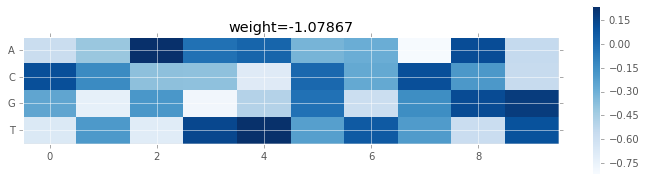

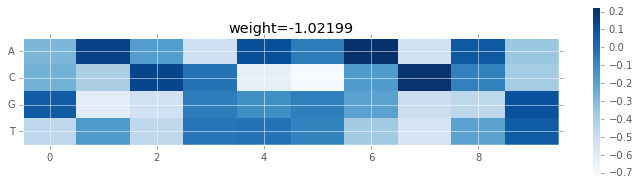

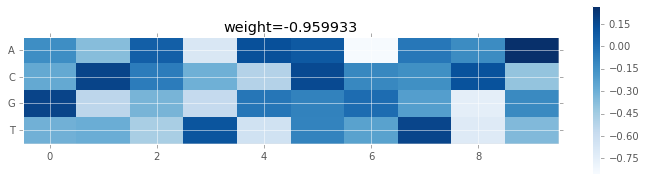

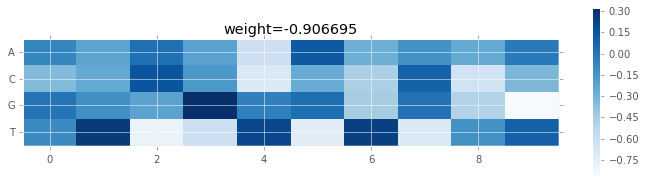

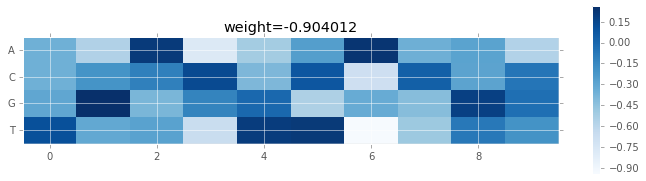

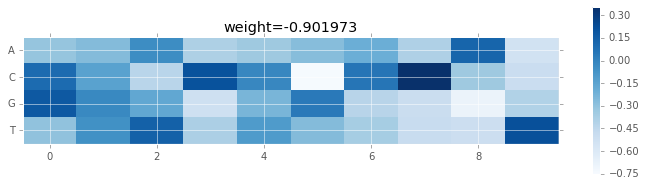

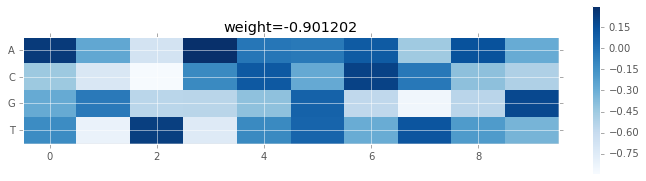

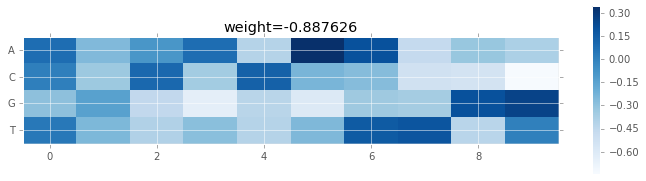

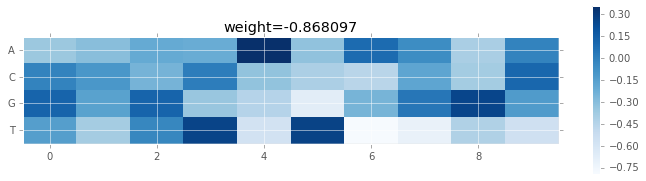

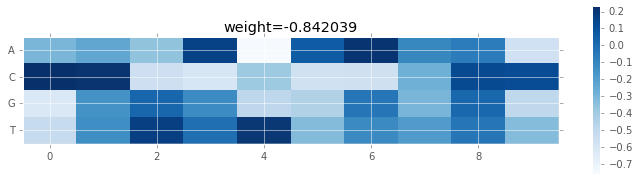

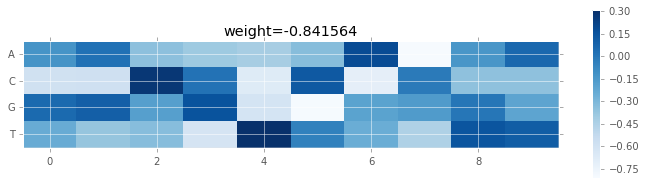

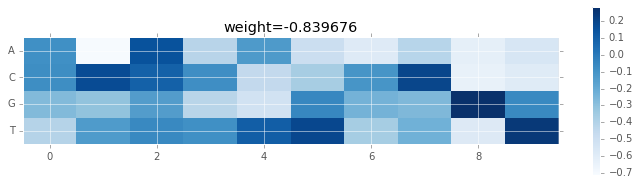

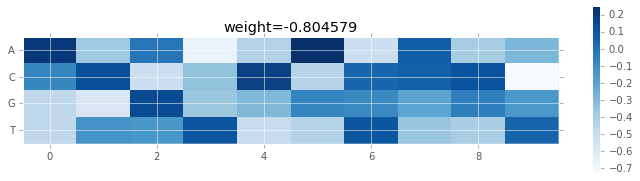

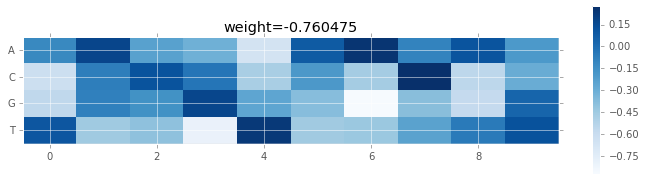

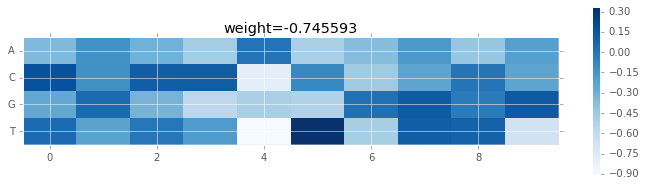

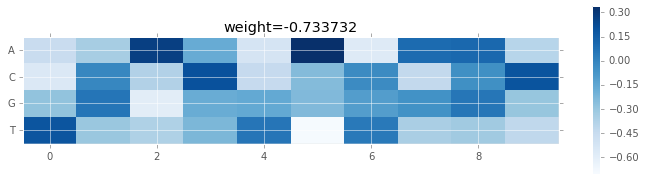

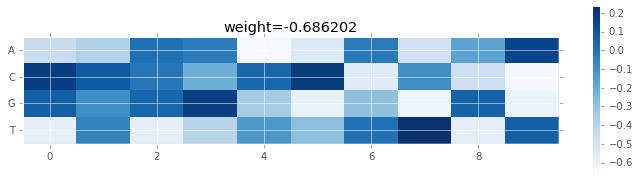

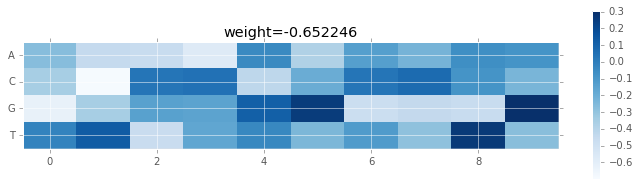

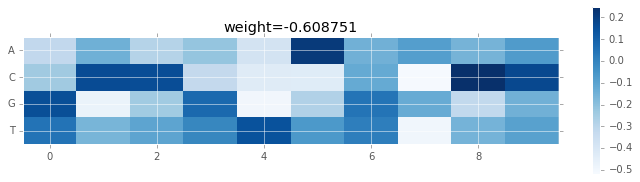

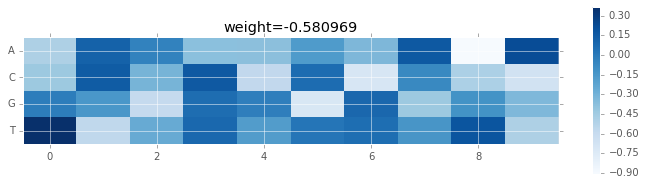

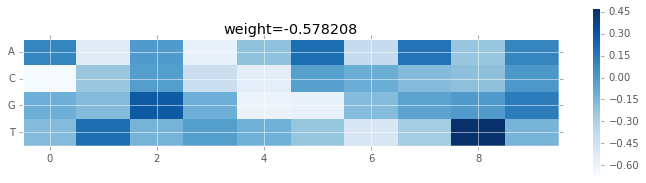

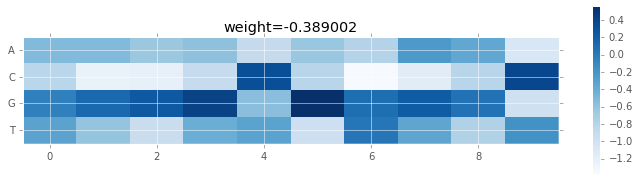

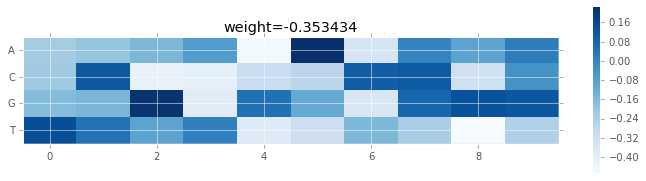

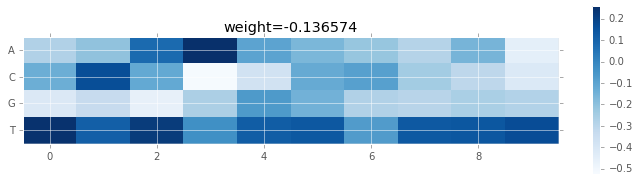

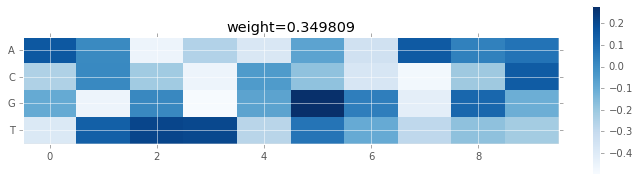

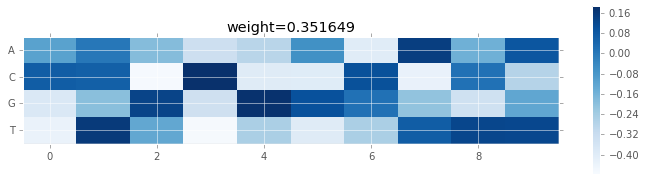

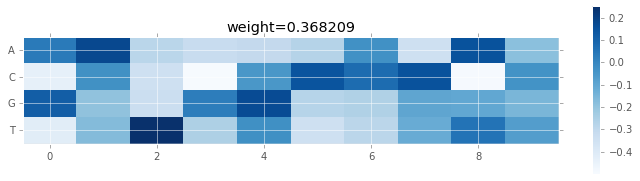

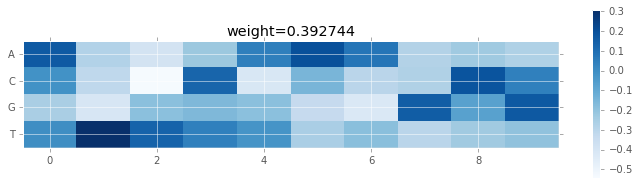

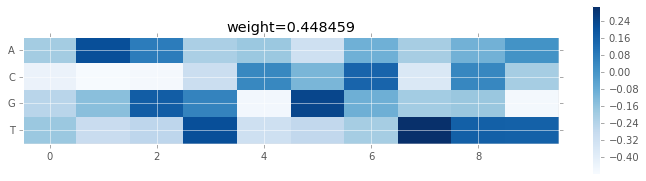

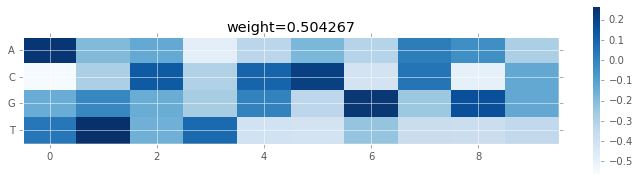

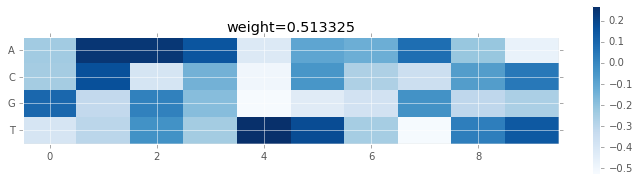

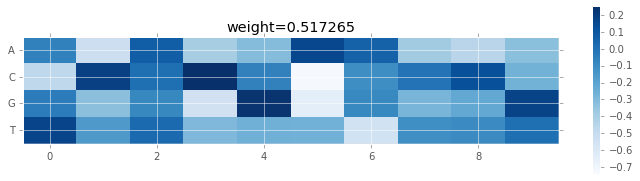

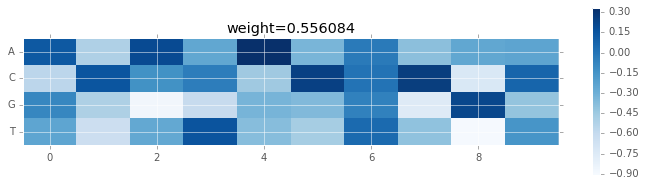

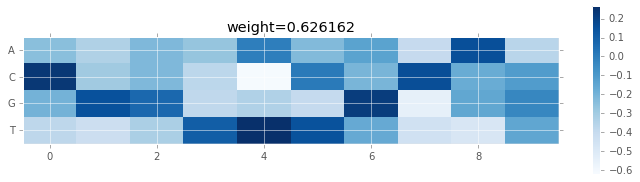

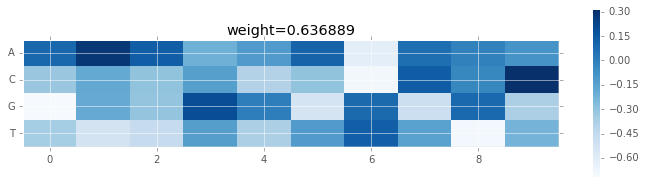

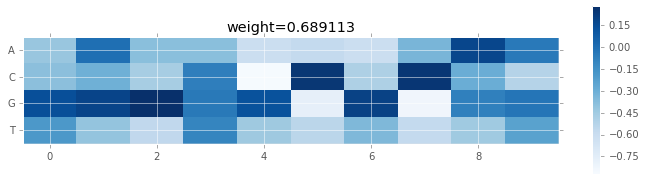

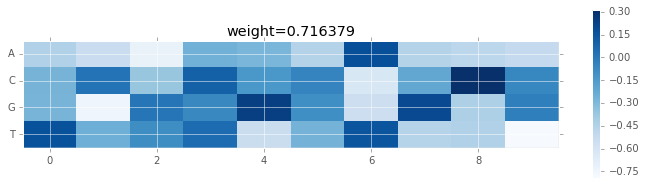

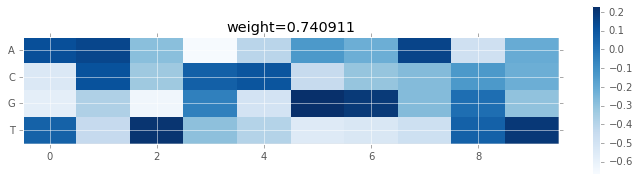

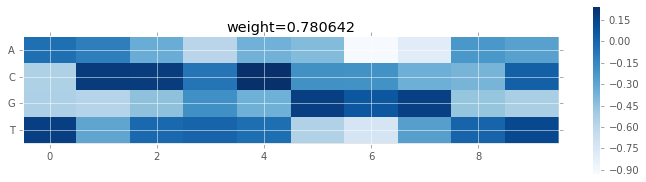

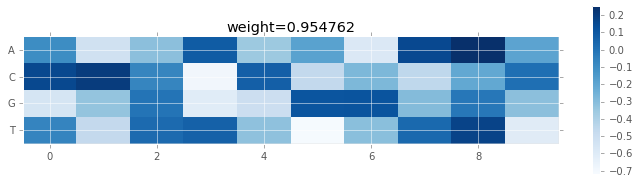

In [14]:
idx=np.argsort(weigths2.flatten())
for w,w2 in zip(weigths[idx],weigths2[idx]):
    plt.figure(figsize=(12,3))
    plt.imshow(w[0].T,interpolation='none',aspect=0.5,cmap='Blues')
    plt.colorbar()
    plt.title('weight='+str(w2[0]))
    dump=plt.yticks([0,1,2,3],['A','C','G','T'])